In [1]:
import os
import json

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
first_group_files=os.listdir("../data/results/test 1")
grid_files = [x for x in first_group_files if "grid" in x]
random_search_files = [x for x in first_group_files if x.find("random")!=-1]
first_group_files = [x for x in first_group_files if x.find("group")!=-1]
sec_and_third_group_files_dir=os.listdir("../data/results/test 2")
sec_and_third_group_files_dir = [x for x in sec_and_third_group_files_dir\
                                 if x.find("old")==-1]

In [3]:
grid_df=pd.DataFrame([])
for file_name in grid_files:
    df = pd.read_csv("../data/results/test 1/"+file_name, usecols = ['experiment_name',
                                                                     'mean_test_score',
                                         'params'])
    
    df['iter_num']=1
    df.loc[df['experiment_name']!='default params', 
           'iter_num'] = range(1, df.loc[df['experiment_name']!='default params'].shape[0]+1)
    
    grid_df = pd.concat([grid_df, df], sort=False)
    
random_df = pd.DataFrame([])
for file_name in random_search_files:
    file_df = pd.read_csv("../data/results/test 1/" + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'params','run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    random_df = pd.concat([random_df, file_df], sort = False)

In [4]:
iters_info = {}
scores_info = {}

In [5]:
stop_iter_num = 100

In [6]:
sec_and_third_group_files = [x for x in sec_and_third_group_files_dir \
                                 if x.find(str(stop_iter_num))!=-1]

In [7]:
gr_2_and_3_df = pd.DataFrame([])
for file_name in sec_and_third_group_files:
    file_df = pd.read_csv("../data/results/test 2/" + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'params','run_number','iter_num'])
    gr_2_and_3_df = pd.concat([gr_2_and_3_df, file_df], sort = False)

In [8]:
end_of_first_part = gr_2_and_3_df.groupby(by='run_number')['iter_num'].min().to_dict()

In [9]:
first_group_df = pd.DataFrame([])
for file_name in first_group_files:
    file_df = pd.read_csv("../data/results/test 1/" + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'params','run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    run_num = np.unique(file_df['run_number'])[0]
    file_df = file_df.loc[file_df['iter_num']<end_of_first_part[run_num]]
    first_group_df = pd.concat([first_group_df, file_df], sort = False)

In [10]:
full_df = pd.concat([first_group_df, gr_2_and_3_df], sort = False)

In [11]:
scores = full_df.groupby('run_number')['mean_test_score'].max()
print("MEAN best score:", np.mean(scores))
print("STD best score:", np.std(scores))

MEAN best score: 0.6680651354998307
STD best score: 0.0013008025390191303


In [12]:
iters_num = full_df.groupby(by='run_number')['iter_num'].max()

In [13]:
print("MEAN iters num:", np.mean(iters_num))
print("STD iters num:", np.std(iters_num))

MEAN iters num: 545.9
STD iters num: 142.87858481941933


In [14]:
max_iter = np.max(iters_num)

In [15]:
max_score_and_iter = full_df.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()

In [16]:
full_df = full_df.loc[:, ['mean_test_score', 'iter_num', 'run_number']]

In [17]:
# Продление конечной оценки до максимальной итерации 
# для отрисовки конца доверительного интервала

In [18]:
list_for_extension = list(max_score_and_iter.loc[
        max_score_and_iter.iter_num < max_iter].index)

In [19]:
full_df = full_df.dropna(how = 'all')

In [22]:
agg_df_GRS = full_df.groupby('run_number')['iter_num'].max().values

iters_info['GRS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(agg_df_GRS), 
    'std':np.nanstd(agg_df_GRS)
}


In [23]:
for run_number in list_for_extension:
    new_part_df = pd.DataFrame([], columns=full_df.columns)
    new_part_df['iter_num']=range(int(max_score_and_iter.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df['run_number'] = run_number
    new_part_df['mean_test_score'] = max_score_and_iter.loc[run_number, 
                                                            'mean_test_score']
    full_df = pd.concat([full_df, new_part_df], sort = False)
    
stopped_full_df = pd.DataFrame([])
for run_number in np.unique(full_df.run_number):
    copy_df = full_df.loc[full_df.run_number == run_number].sort_values(by = 'iter_num')
    copy_df['mean_test_score']=copy_df['mean_test_score'].cummax()
    copy_df['run_number']=run_number
    #full_df.loc[full_df.run_number == run_number]=full_df.loc[full_df.run_number == run_number].sort_values(by = 'iter_num')
    #full_df.loc[full_df.run_number == run_number, 'mean_test_score'] = \
    #    full_df.loc[full_df.run_number == run_number, 'mean_test_score'].cummax()
    stopped_full_df = pd.concat([stopped_full_df, copy_df], sort=False)


In [24]:
full_df = stopped_full_df

In [25]:
full_df['experiment_name']='group search'

In [26]:
## RANDOM_SEARCH
#get best scores per itration for each random_search performance:
random_df_stopped=pd.DataFrame([])
max_iters_for_RS = []
for i in random_df.run_number.unique():    
    tmp=pd.DataFrame(random_df.loc[random_df.run_number==i, 
                                   "mean_test_score"].copy().cummax())
    tmp["iter_num"]=random_df.loc[random_df.run_number==i, "iter_num"]
    curr_max=tmp.groupby("mean_test_score").count().reset_index()
    max_score=curr_max.loc[curr_max["iter_num"]>=stop_iter_num, 
                           "mean_test_score"].values[0]
    
    tmp_before=tmp.loc[tmp["mean_test_score"]<max_score] #get steps before stop criterion
    tmp_stop=tmp.loc[tmp["mean_test_score"]==max_score].sort_values(by="iter_num")
    tmp_stop=tmp_stop.iloc[:stop_iter_num]
    df_stopped=pd.concat([tmp_before, tmp_stop], sort = False)  
    df_stopped['run_number']=i
    max_iters_for_RS.append(df_stopped.shape[0])
    random_df_stopped=pd.concat([random_df_stopped, df_stopped], sort=False)
    
    
print("MEAN iters num:", np.mean(max_iters_for_RS))
print("STD iters num:", np.std(max_iters_for_RS))

MEAN iters num: 195.0
STD iters num: 48.20165972246184


In [27]:
iters_info['RS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(max_iters_for_RS), 
    'std':np.nanstd(max_iters_for_RS)
}

In [28]:
last_iter = random_df_stopped.groupby(by = 'run_number')['iter_num'].max().reset_index()

In [29]:
max_iter = np.max(max_iters_for_RS)
max_score_and_iter_RS = random_df_stopped.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()
for run_number in list(max_score_and_iter_RS.loc[
        max_score_and_iter_RS.iter_num < max_iter].index):
    new_part_df = pd.DataFrame([], columns=random_df_stopped.columns )
    new_part_df['iter_num']=range(int(max_score_and_iter_RS.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df[['mean_test_score', 'run_number']] = max_score_and_iter_RS.loc[run_number, 'mean_test_score'], run_number
    random_df_stopped = pd.concat([random_df_stopped, new_part_df])
random_df_stopped['experiment_name']='random search'   

In [30]:
#get info for grid and deafault

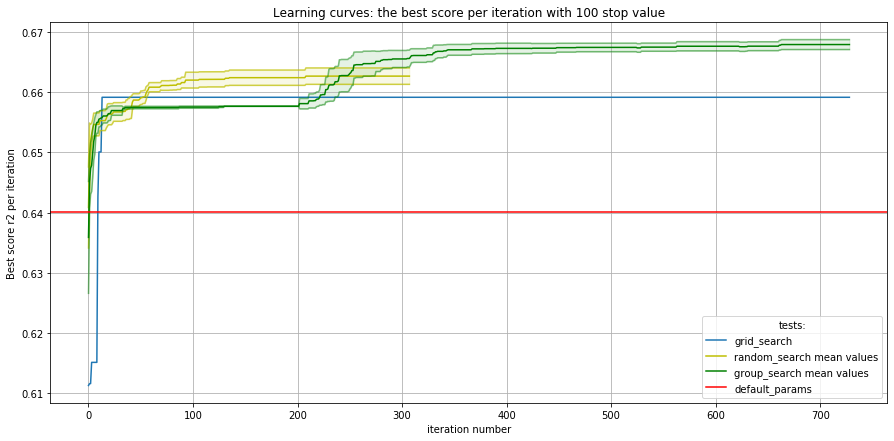

In [31]:
# Data with stop criterion
# stop if the cumulative score hasn't grown in "stop_iter_num" iterations
# GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params',
                      'mean_test_score'].cummax()


## RANDOM_SEARCH
# get best scores per itration for each random_search performance:
# random_df_stopped
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=10
random_std=random_df_stopped.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_df_stopped.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):

n=10
group_std=full_df.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_std=group_std.fillna(0)
group_mean=full_df.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=grid_df.loc[grid_df['experiment_name']=='default params', 'mean_test_score']


## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#grid plot:
x=list(range(0, grid_perf.shape[0]))
plt.plot(x, grid_perf, label="grid_search")

#conf for random:
x=list(range(0, random_mean.shape[0]))
plt.plot(x, random_mean, color="y", label="random_search mean values")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
x=list(range(0, group_mean.shape[0]))
plt.plot(x, group_mean, color="green", label="group_search mean values")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values, label="default_params", color='r')

plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration with {} stop value".format(stop_iter_num))
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.savefig("../graphs/test 2/scores_with_stop_{}.jpg".format(stop_iter_num))
plt.show()

In [32]:
agg_df_GRS = full_df.groupby('run_number')['mean_test_score'].max().values
agg_df_RS = random_df_stopped.groupby('run_number')['mean_test_score'].max().values

In [34]:
scores_info['GRS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(agg_df_GRS), 
    'std':np.nanstd(agg_df_GRS)
}
scores_info['RS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(agg_df_RS), 
    'std':np.nanstd(agg_df_RS)
}

In [35]:
scores_info

{'GRS_100': {'mean': 0.6680651354998307, 'std': 0.0013008025390191303},
 'RS_100': {'mean': 0.6627090283296673, 'std': 0.0020875533780410765}}

In [36]:
iters_info

{'GRS_100': {'mean': 729.0, 'std': 0.0},
 'RS_100': {'mean': 195.0, 'std': 48.20165972246184}}

In [ ]:
with open("../data/results/test 2/scores_info.txt", 'w') as outfile:
    json.dump(scores_info, outfile)
    

with open("../data/results/test 2/iters_info.txt", 'w') as outfile:
    json.dump(iters_info, outfile)

